## Invoice Management System
The buyer business needs to clear its amount due before the due date. However, in real-world scenarios , the invoices are not always cleared ie. paid in full amount by the due date.
## Objective is  to predict the payment date
The date on which a customer clears the payment for an invoice is called the payment date.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

from numpy.random import seed
from numpy.random import randn
from numpy import mean
from numpy import std

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from currency_converter import CurrencyConverter
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
# Read the dataset from the file
df = pd.read_csv("H2HBABBA1602.csv")

## Data Pre-processing

In [3]:
# Have a look at the dataset
df.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
0,U001,0200772595,SAFEW trust,2019-06-11 00:00:00,2019.0,1.929384e+09,2019-05-27,20190527,20190527,20190611.0,USD,RV,1.0,NaN,83749.22,20190527.0,NAA8,1.929384e+09,0
1,U001,0200769623,WAL-MAR corp,2019-06-21 00:00:00,2019.0,1.929435e+09,2019-06-06,20190605,20190606,20190621.0,USD,RV,1.0,NaN,6652.71,20190606.0,NAH4,1.929435e+09,0
2,U001,200793568,SUPE associates,2019-03-15 00:00:00,2019.0,1.928860e+09,2019-02-26,20190226,20190226,20190313.0,USD,RV,1.0,NaN,33101.28,20190226.0,NAA8,1.928860e+09,0
3,U001,0200726979,BJ'S associates,2019-03-28 00:00:00,2019.0,1.928940e+09,2019-03-11,20190311,20190311,20190326.0,USD,RV,1.0,NaN,74906.37,20190311.0,NAA8,1.928940e+09,0
4,U001,0200799367,MCL co,NaN,2020.0,1.930598e+09,2020-03-11,20200304,20200311,20200326.0,USD,RV,1.0,NaN,7617.62,20200311.0,NAA8,1.930598e+09,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   business_code           50000 non-null  object 
 1   cust_number             50000 non-null  object 
 2   name_customer           50000 non-null  object 
 3   clear_date              40000 non-null  object 
 4   buisness_year           50000 non-null  float64
 5   doc_id                  50000 non-null  float64
 6   posting_date            50000 non-null  object 
 7   document_create_date    50000 non-null  int64  
 8   document_create_date.1  50000 non-null  int64  
 9   due_in_date             50000 non-null  float64
 10  invoice_currency        50000 non-null  object 
 11  document type           50000 non-null  object 
 12  posting_id              50000 non-null  float64
 13  area_business           0 non-null      float64
 14  total_open_amount       50000 non-null

### Removing train data

In [5]:
# Lets see the total rows in the dataset
print(df['business_code'].count())

# As we are having 'clear_date' as out target prediction so let's analyse that.
# We are having 40,000 closed invoices so it is the training dataset
print(df[df['isOpen'] == 0]['business_code'].count())

# Counting the open invoices we do have 10,000, so they are the testing dataset
# As the clear_date in this case is expected to be null we get count as 0
print(df[df['isOpen'] == 1]['clear_date'].count())

# Now changing the clear_date to some other values to just count the number of test data
print(df[df['isOpen'] == 1]['business_code'].count())

50000
40000
0
10000


In [6]:
# Now lets use the 'isOpen' column split between train data and test data
train_data = pd.DataFrame(df[df['isOpen'] == 0])
# For fitting in the model
real_time_test_data = pd.DataFrame(df[df['isOpen'] == 1])
# For final dataset
final_data = pd.DataFrame(df[df['isOpen'] == 1])

# After this split isOpen becomes a constant
# But the 'isOpen' column is still available so lets drop that as after splitting it becomes a constant
train_data.drop(['isOpen'], axis=1, inplace=True)
real_time_test_data.drop(['isOpen'], axis=1, inplace=True)

###  Null Imputation

In [7]:
# Check for the null count of all the coulmns
train_data.isna().sum()

business_code                 0
cust_number                   0
name_customer                 0
clear_date                    0
buisness_year                 0
doc_id                        0
posting_date                  0
document_create_date          0
document_create_date.1        0
due_in_date                   0
invoice_currency              0
document type                 0
posting_id                    0
area_business             40000
total_open_amount             0
baseline_create_date          0
cust_payment_terms            0
invoice_id                    3
dtype: int64

In [8]:
# There are total 40,000 rows and area_business has all of them null, so let's drop it
train_data.drop(['area_business'], axis = 1, inplace = True)

In [9]:
# Let's see which rows of invoice_id are null
train_data[train_data['invoice_id'].isna()]

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id
2185,CA02,0140106054,TREE llc,2019-05-22 00:00:00,2019.0,9.500000e+09,2019-03-29,20190329,20190301,20190311.0,CAD,X2,1.0,21245.76,20190301.0,CA10,NaN
27942,CA02,0100030194,AMAZO foundation,2019-12-27 00:00:00,2019.0,9.500000e+09,2019-03-29,20190329,20190320,20190330.0,CAD,X2,1.0,1326.00,20190320.0,CA10,NaN
31266,CA02,0140104409,LOB associates,2019-12-27 00:00:00,2019.0,9.500000e+09,2019-03-29,20190329,20180626,20180706.0,CAD,X2,1.0,279.60,20180626.0,CA10,NaN


### Check for duplicate rows

In [10]:
# We have some duplicate rows which needs to be dropped
print(train_data.duplicated().sum())
train_data = train_data.drop_duplicates(keep = 'last')

853


### Handling Object type data

In [11]:
# Any type of ID or Name having so many unique values,
# doesn't really helps us to predict something
print("name_customer:", train_data['name_customer'].nunique())
print("doc_id:", train_data['doc_id'].nunique())
print("invoice_id:", train_data['invoice_id'].nunique())

# So let's remove them
train_data.drop(['name_customer', 'doc_id', 'invoice_id'], axis = 1, inplace = True)

name_customer: 3958
doc_id: 39147
invoice_id: 39144


### Looking for any constant columns

In [12]:
# Let's have a look at the unique values count
train_data.nunique()

business_code                 6
cust_number                1340
clear_date                  402
buisness_year                 2
posting_date                422
document_create_date        424
document_create_date.1      423
due_in_date                 492
invoice_currency              2
document type                 2
posting_id                    1
total_open_amount         35703
baseline_create_date        432
cust_payment_terms           65
dtype: int64

In [13]:
# Posting ID has only 1 value and it's a constant column and can be removed
print(train_data['posting_id'].head(2))
train_data.drop(['posting_id'], axis = 1, inplace = True)

0    1.0
1    1.0
Name: posting_id, dtype: float64


In [14]:
# Document type has only 3 rows having X2, so this is a quasi-constant and can be removed
print(train_data['document type'].value_counts())
train_data.drop(['document type'], axis = 1, inplace = True)

RV    39144
X2        3
Name: document type, dtype: int64


### Convert to datetime format

In [15]:
# Function to handle special datetime format with no space,
# or any special characters
def handle_no_space_date(val):
    
    val = str(val)
    y = val[0:4]
    m = val[4:6]
    d = val[6:8]
    
    return y + '-' + m + '-' + d

# Working with date, parsing as datetime format
train_data['clear_date'] = pd.to_datetime(train_data['clear_date'])
train_data['posting_date'] = pd.to_datetime(train_data['posting_date'])
train_data['document_create_date'] = pd.to_datetime(train_data['document_create_date'].apply(handle_no_space_date))
train_data['document_create_date.1'] = pd.to_datetime(train_data['document_create_date.1'].apply(handle_no_space_date))
train_data['due_in_date'] = pd.to_datetime(train_data['due_in_date'].apply(handle_no_space_date))
train_data['baseline_create_date'] = pd.to_datetime(train_data['baseline_create_date'].apply(handle_no_space_date))

In [16]:
# If we see the data it seems like document_create_date.1 and posting date are same,
# so lets check
print((train_data['document_create_date.1'] == train_data['posting_date']).count())

# Hence, it's clear that it is the duplicate column and can be dropped
train_data.drop(['document_create_date.1'], axis = 1, inplace = True)

39147


### Modifying categorical column having low unique values

In [17]:
train_data.nunique()

business_code               6
cust_number              1340
clear_date                402
buisness_year               2
posting_date              422
document_create_date      424
due_in_date               492
invoice_currency            2
total_open_amount       35703
baseline_create_date      432
cust_payment_terms         65
dtype: int64

In [18]:
# Invoice currency have only 2 unique values so let's keep them for now
print(train_data['invoice_currency'].value_counts())

USD    35992
CAD     3155
Name: invoice_currency, dtype: int64


In [19]:
train_data['cust_payment_terms'].unique()

array(['NAA8', 'NAH4', 'CA10', 'NAM4', 'NAU5', 'NAWU', 'NAM2', 'NAAX',
       'NAC6', 'NAG2', 'NAD1', 'NACB', 'NAGD', 'NAX2', 'NAD5', 'NAAW',
       'NAWN', 'NA10', 'NAM1', 'NA32', 'NAVE', 'NAVF', 'NA31', 'NA3F',
       'NAD4', 'NABG', 'NAVM', 'NAVQ', 'NA38', 'NAVR', 'NAVL', 'NAWP',
       'NA3B', 'C106', 'NA9X', 'CA30', 'NAUZ', 'NAVD', 'NAUW', 'NA8Q',
       'CAB1', 'NANC', 'BR12', 'B052', 'NAUI', 'NAB1', 'NAUX', '90M7',
       'NATZ', 'NAM3', 'NATJ', 'BR56', 'NAVC', 'NAV2', 'NA25', 'NATH',
       'NAUP', 'NATU', 'NATK', 'NATL', 'NACE', 'NA84', 'NAV9', 'NATW',
       'NAD8'], dtype=object)

In [20]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39147 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   business_code         39147 non-null  object        
 1   cust_number           39147 non-null  object        
 2   clear_date            39147 non-null  datetime64[ns]
 3   buisness_year         39147 non-null  float64       
 4   posting_date          39147 non-null  datetime64[ns]
 5   document_create_date  39147 non-null  datetime64[ns]
 6   due_in_date           39147 non-null  datetime64[ns]
 7   invoice_currency      39147 non-null  object        
 8   total_open_amount     39147 non-null  float64       
 9   baseline_create_date  39147 non-null  datetime64[ns]
 10  cust_payment_terms    39147 non-null  object        
dtypes: datetime64[ns](5), float64(2), object(4)
memory usage: 3.6+ MB


In [21]:
# Final look on the value counts and null values(if any)
print("Value counts...\n", train_data.nunique())
print("\nNull counts...\n.", train_data.isna().sum())

Value counts...
 business_code               6
cust_number              1340
clear_date                402
buisness_year               2
posting_date              422
document_create_date      424
due_in_date               492
invoice_currency            2
total_open_amount       35703
baseline_create_date      432
cust_payment_terms         65
dtype: int64

Null counts...
. business_code           0
cust_number             0
clear_date              0
buisness_year           0
posting_date            0
document_create_date    0
due_in_date             0
invoice_currency        0
total_open_amount       0
baseline_create_date    0
cust_payment_terms      0
dtype: int64


###### We need to predict the duration of delay, so it's required before splitting the data

In [22]:
# We cannot specially predict date here, so we go with days count.
# Count and create a new column 'delay_days' and remove clear date column.
train_data['delay_days'] = (train_data['clear_date'] - train_data['due_in_date']).dt.days
train_data['total_duration'] = (train_data['due_in_date'] - train_data['posting_date']).dt.days
train_data.drop(['clear_date'], axis = 1, inplace = True)

In [23]:
# Added delay_days to the end
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39147 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   business_code         39147 non-null  object        
 1   cust_number           39147 non-null  object        
 2   buisness_year         39147 non-null  float64       
 3   posting_date          39147 non-null  datetime64[ns]
 4   document_create_date  39147 non-null  datetime64[ns]
 5   due_in_date           39147 non-null  datetime64[ns]
 6   invoice_currency      39147 non-null  object        
 7   total_open_amount     39147 non-null  float64       
 8   baseline_create_date  39147 non-null  datetime64[ns]
 9   cust_payment_terms    39147 non-null  object        
 10  delay_days            39147 non-null  int64         
 11  total_duration        39147 non-null  int64         
dtypes: datetime64[ns](4), float64(2), int64(2), object(4)
memory usage: 3.9+ M

## Splitting data

In [24]:
# Now let's split the validation data and train data from the train dataset
# As this is a timeline based dataset, 
# As this is a small dataset, it would be good for a 70/15/15 split
per_70 = int(train_data['total_open_amount'].count() * 0.7)
per_30 = int(train_data['total_open_amount'].count() * 0.3)
print(per_70, per_30)

val_data = train_data[-per_30:]
train_data = train_data[:per_70]

27402 11744


In [25]:
# Printing shapes of three splitted dataset
print(train_data.shape, val_data.shape)

(27402, 12) (11744, 12)


In [26]:
# Now splitting to X_train, y_train, X_val inorder to fit in model
X_train = train_data.drop(['delay_days'], axis = 1)
y_train = train_data['delay_days']

# For validation and test set
X_val = val_data.drop(['delay_days'], axis = 1)
y_val = val_data['delay_days']

# Shape of data
print("Train      data: ", X_train.shape, y_train.shape)
print("Validation data: ", X_val.shape)

Train      data:  (27402, 11) (27402,)
Validation data:  (11744, 11)


## EDA and Feature Engg

#### Treating object type variables

In [27]:
# Merging y_train temporarily with y_train for analysis
X_train = train_data

In [28]:
X_train

,business_code,cust_number,buisness_year,posting_date,document_create_date,due_in_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms,delay_days,total_duration
0,U001,0200772595,2019.0,2019-05-27,2019-05-27,2019-06-11,USD,83749.22,2019-05-27,NAA8,0,15
1,U001,0200769623,2019.0,2019-06-06,2019-06-05,2019-06-21,USD,6652.71,2019-06-06,NAH4,0,15
2,U001,200793568,2019.0,2019-02-26,2019-02-26,2019-03-13,USD,33101.28,2019-02-26,NAA8,2,15
3,U001,0200726979,2019.0,2019-03-11,2019-03-11,2019-03-26,USD,74906.37,2019-03-11,NAA8,2,15
5,U001,0200797452,2019.0,2019-03-11,2019-03-11,2019-03-26,USD,72381.70,2019-03-11,NAA8,1,15
...,...,...,...,...,...,...,...,...,...,...,...,...
35271,U001,0200126819,2019.0,2019-03-06,2019-03-04,2019-03-21,USD,299.49,2019-03-06,NAA8,-1,15
35272,U013,0140103409,2019.0,2019-03-25,2019-03-21,2019-04-24,USD,16603.61,2019-03-25,NAVE,-6,30
35273,U001,0200772670,2019.0,2019-09-20,2019-09-20,2019-10-05,USD,20930.07,2019-09-20,NAU5,-1,15
35274,U013,0100009932,2019.0,2019-10-28,2019-10-24,2019-11-27,USD,2184.00,2019-10-28,NAVE,2,30


### Handling currency and total amount
##### Getting the latest currency exchange value from API

In [29]:
# There are only two currencies
print(X_train['invoice_currency'].unique())

# Function to convert CAD to USD
cur_covt = CurrencyConverter()
rate = cur_covt.convert(1, 'CAD', 'USD')

# Working on rows having currency as CAD
X_train.loc[X_train['invoice_currency'] == 'CAD', 'total_open_amount'] = X_train['total_open_amount'] * rate

# Current exchange rate
print("1 CAD = %.2f USD " % (rate))
X_train.drop(['invoice_currency'], axis = 1, inplace = True)

['USD' 'CAD']
1 CAD = 0.83 USD 


### Encoding categorical columns

In [30]:
# Label encoding business code, customer number and customer payment terms

# For business_code
enc = LabelEncoder()
enc.fit(X_train['business_code'])
X_train['business_code_enc'] = enc.transform(X_train['business_code'])

# For cust_number
enc = LabelEncoder()
enc.fit(X_train['cust_number'])
X_train['cust_number_enc'] = enc.transform(X_train['cust_number'])

# For cust_payment_terms
enc = LabelEncoder()
enc.fit(X_train['cust_payment_terms'])
X_train['cust_payment_terms_enc'] = enc.transform(X_train['cust_payment_terms'])

# Drop object type columns
train_data.drop(['business_code', 'cust_number', 'cust_payment_terms'], axis = 1, inplace = True)

# Let's have a look
X_train.head()

,buisness_year,posting_date,document_create_date,due_in_date,total_open_amount,baseline_create_date,delay_days,total_duration,business_code_enc,cust_number_enc,cust_payment_terms_enc
0,2019.0,2019-05-27,2019-05-27,2019-06-11,83749.22,2019-05-27,0,15,1,766,18
1,2019.0,2019-06-06,2019-06-05,2019-06-21,6652.71,2019-06-06,0,15,1,760,31
2,2019.0,2019-02-26,2019-02-26,2019-03-13,33101.28,2019-02-26,2,15,1,1153,18
3,2019.0,2019-03-11,2019-03-11,2019-03-26,74906.37,2019-03-11,2,15,1,666,18
5,2019.0,2019-03-11,2019-03-11,2019-03-26,72381.70,2019-03-11,1,15,1,836,18


### Checking for any quasi-constant

In [31]:
# Fit training data in quasi_constant filter
X_train_numerical = X_train.drop(['posting_date', 'document_create_date', 'due_in_date',
                                  'baseline_create_date'], axis = 1, inplace = False)

quasi_const_filter = VarianceThreshold(threshold=0.2)
quasi_const_filter.fit(X_train_numerical)

# Let's find the columns
columns = [i for i in X_train_numerical.columns if i not in X_train_numerical.columns[quasi_const_filter.get_support()]]
print(columns)
X_train.drop(['buisness_year'], axis = 1, inplace = True)

['buisness_year']


### Normalisation of columns

In [32]:
# Columns having numbers not 0 to 1, it might be a dominant feature so it can be normalised
X_train['total_open_amount'] = (X_train['total_open_amount'] - X_train['total_open_amount'].min()) / (X_train['total_open_amount'].max() - X_train['total_open_amount'].min())
X_train['total_duration'] = (X_train['total_duration'] - X_train['total_duration'].min()) / (X_train['total_duration'].max() - X_train['total_duration'].min())
X_train['business_code_enc'] = (X_train['business_code_enc'] - X_train['business_code_enc'].min()) / (X_train['business_code_enc'].max() - X_train['business_code_enc'].min())
X_train['cust_number_enc'] = (X_train['cust_number_enc'] - X_train['cust_number_enc'].min()) / (X_train['cust_number_enc'].max() - X_train['cust_number_enc'].min())
X_train['cust_payment_terms_enc'] = (X_train['cust_payment_terms_enc'] - X_train['cust_payment_terms_enc'].min()) / (X_train['cust_payment_terms_enc'].max() - X_train['cust_payment_terms_enc'].min())

X_train

,posting_date,document_create_date,due_in_date,total_open_amount,baseline_create_date,delay_days,total_duration,business_code_enc,cust_number_enc,cust_payment_terms_enc
0,2019-05-27,2019-05-27,2019-06-11,0.105636,2019-05-27,0,0.726098,0.2,0.635158,0.285714
1,2019-06-06,2019-06-05,2019-06-21,0.008385,2019-06-06,0,0.726098,0.2,0.630182,0.492063
2,2019-02-26,2019-02-26,2019-03-13,0.041748,2019-02-26,2,0.726098,0.2,0.956053,0.285714
3,2019-03-11,2019-03-11,2019-03-26,0.094481,2019-03-11,2,0.726098,0.2,0.552239,0.285714
5,2019-03-11,2019-03-11,2019-03-26,0.091296,2019-03-11,1,0.726098,0.2,0.693201,0.285714
...,...,...,...,...,...,...,...,...,...,...
35271,2019-03-06,2019-03-04,2019-03-21,0.000371,2019-03-06,-1,0.726098,0.2,0.358209,0.285714
35272,2019-03-25,2019-03-21,2019-04-24,0.020937,2019-03-25,-6,0.764858,1.0,0.246269,0.857143
35273,2019-09-20,2019-09-20,2019-10-05,0.026395,2019-09-20,-1,0.726098,0.2,0.635987,0.698413
35274,2019-10-28,2019-10-24,2019-11-27,0.002748,2019-10-28,2,0.764858,1.0,0.023217,0.857143


### Checking if date type columns can have some trends

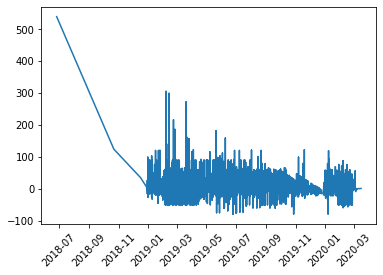

In [33]:
# We have date type columns in the dataset which needs to be removed
# Let's see if we can find any trends from baseline_create_date
X_train = X_train.sort_values(by = ['baseline_create_date'], ascending = True)
plt.xticks(rotation=45)
plt.plot(X_train['baseline_create_date'], X_train['delay_days'])
# This graph doesn't provide us with much features.

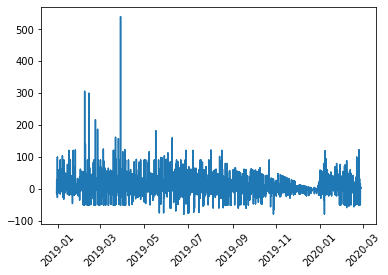

In [34]:
# Let's see with other columns
# Now let's sort the data in ascending order of posting_date,
# to get a timelined data may help in some features like,
X_train = X_train.sort_values(by = ['posting_date'], ascending = True)
plt.xticks(rotation=45)
plt.plot(X_train['posting_date'], X_train['delay_days'])
# delay_date is low to the year's end

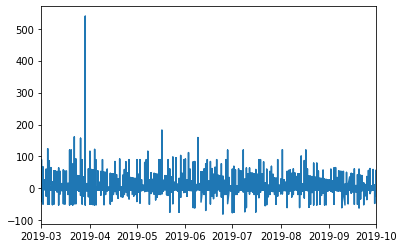

In [35]:
plt.xlim(pd.to_datetime('2019-03', format = '%Y-%m'), pd.to_datetime('2019-10', format = '%Y-%m'))
plt.plot(X_train['posting_date'], X_train['delay_days'])
X_train.drop(['posting_date'], axis = 1, inplace = True)

# From the graph we can observe a trend that,
# the delay reduce during the year end and also some similarities in month end
# So I sliced the data rather than random suffling

In [36]:
# Seems like document create date and baseline doen't have much trends, 
# So they can be dropped
X_train.drop(['document_create_date', 'baseline_create_date'], axis = 1, inplace = True)

In [37]:
# It might happen that the due dates may be some holidays or something like that.
# Let's see if these kind of features exists.

# Days of due dates
X_train['week_days'] = X_train['due_in_date'].dt.weekday
X_train = pd.get_dummies(X_train, columns = ['week_days'], prefix = 'week', drop_first = True)

# Now it's time to drop due_in_date as we extracted all the useful features
X_train.drop(['due_in_date'], axis = 1, inplace = True)

## Feature Selection

In [38]:
X_train

,total_open_amount,delay_days,total_duration,business_code_enc,cust_number_enc,cust_payment_terms_enc,week_1,week_2,week_3,week_4,week_5,week_6
7002,0.025466,26,0.777778,0.2,0.997512,0.460317,0,0,0,0,0,1
25596,0.032263,1,0.726098,0.2,0.612769,0.492063,0,0,0,0,0,0
4111,0.164525,0,0.726098,0.2,0.523217,0.285714,0,0,0,0,0,0
25291,0.017996,1,0.726098,0.2,0.612769,0.492063,0,0,0,0,0,0
18993,0.015902,-5,0.726098,0.2,0.630182,0.492063,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11087,0.038233,0,0.726098,0.2,0.653400,0.285714,0,0,1,0,0,0
5623,0.036058,1,0.726098,0.2,0.606136,0.285714,0,0,1,0,0,0
29593,0.008288,0,0.726098,0.2,0.732172,0.285714,0,0,1,0,0,0
21051,0.003169,1,0.739018,0.2,0.651741,0.412698,0,1,0,0,0,0


In [39]:
X_train.corr()

,total_open_amount,delay_days,total_duration,business_code_enc,cust_number_enc,cust_payment_terms_enc,week_1,week_2,week_3,week_4,week_5,week_6
total_open_amount,1.000000,0.001390,-0.066256,-0.083609,-0.061402,-0.180091,0.005866,0.004185,0.017204,0.011515,-0.011344,0.000547
delay_days,0.001390,1.000000,-0.265384,-0.015151,0.091751,0.043265,-0.005364,-0.028814,0.005862,0.024480,0.015999,0.001290
total_duration,-0.066256,-0.265384,1.000000,0.251039,-0.001494,0.241863,-0.021830,0.002587,-0.013419,-0.005076,-0.009794,0.026280
business_code_enc,-0.083609,-0.015151,0.251039,1.000000,0.117226,0.505054,0.013366,0.039378,0.021442,-0.018838,-0.021616,-0.026701
cust_number_enc,-0.061402,0.091751,-0.001494,0.117226,1.000000,0.367499,0.011904,0.038760,0.013691,-0.004677,-0.006660,-0.025333
cust_payment_terms_enc,-0.180091,0.043265,0.241863,0.505054,0.367499,1.000000,0.018259,0.020255,-0.009603,-0.050453,-0.039393,0.019589
week_1,0.005866,-0.005364,-0.021830,0.013366,0.011904,0.018259,1.000000,-0.172242,-0.179327,-0.172936,-0.172768,-0.145779
week_2,0.004185,-0.028814,0.002587,0.039378,0.038760,0.020255,-0.172242,1.000000,-0.191493,-0.184669,-0.184490,-0.155669
week_3,0.017204,0.005862,-0.013419,0.021442,0.013691,-0.009603,-0.179327,-0.191493,1.000000,-0.192265,-0.192078,-0.162073
week_4,0.011515,0.024480,-0.005076,-0.018838,-0.004677,-0.050453,-0.172936,-0.184669,-0.192265,1.000000,-0.185233,-0.156297


In [40]:
X_train.cov()

,total_open_amount,delay_days,total_duration,business_code_enc,cust_number_enc,cust_payment_terms_enc,week_1,week_2,week_3,week_4,week_5,week_6
total_open_amount,0.002250,0.000784,-0.000088,-0.000437,-0.000546,-0.001508,0.000096,0.000072,0.000304,0.000198,-0.000195,0.000008
delay_days,0.000784,141.492430,-0.088885,-0.019842,0.204626,0.090838,-0.022066,-0.124157,0.025957,0.105776,0.069086,0.004921
total_duration,-0.000088,-0.088885,0.000793,0.000778,-0.000008,0.001202,-0.000213,0.000026,-0.000141,-0.000052,-0.000100,0.000237
business_code_enc,-0.000437,-0.019842,0.000778,0.012122,0.002420,0.009815,0.000509,0.001571,0.000879,-0.000753,-0.000864,-0.000943
cust_number_enc,-0.000546,0.204626,-0.000008,0.002420,0.035154,0.012162,0.000772,0.002633,0.000956,-0.000319,-0.000453,-0.001523
cust_payment_terms_enc,-0.001508,0.090838,0.001202,0.009815,0.012162,0.031155,0.001115,0.001295,-0.000631,-0.003235,-0.002524,0.001109
week_1,0.000096,-0.022066,-0.000213,0.000509,0.000772,0.001115,0.119608,-0.021579,-0.023089,-0.021726,-0.021690,-0.016170
week_2,0.000072,-0.124157,0.000026,0.001571,0.002633,0.001295,-0.021579,0.131224,-0.025825,-0.024300,-0.024260,-0.018086
week_3,0.000304,0.025957,-0.000141,0.000879,0.000956,-0.000631,-0.023089,-0.025825,0.138602,-0.026001,-0.025959,-0.019352
week_4,0.000198,0.105776,-0.000052,-0.000753,-0.000319,-0.003235,-0.021726,-0.024300,-0.026001,0.131952,-0.024426,-0.018209


## Outlier detection

### In delay_days

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


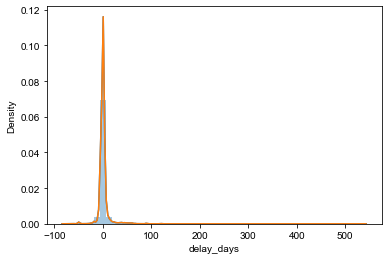

In [41]:
# Distribution plot of delay_days
print(sns.distplot(X_train['delay_days']))
sns.set_style('white')
print(sns.kdeplot(X_train['delay_days']))

In [42]:
# Standard Deviation Method

# seed the random number generator
seed(1)

# Calculate summary statistics
data_mean, data_std = mean(X_train['delay_days']), std(X_train['delay_days'])

# Identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off

# Count outliers
outliers = [x for x in X_train['delay_days'] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))

# Count non-outliers
outliers_removed = [x for x in X_train['delay_days'] if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

# Actually remove the outliers
X_train = X_train[(X_train['delay_days'] >= lower) & (X_train['delay_days'] <= upper)]

Identified outliers: 689
Non-outlier observations: 26713


### In total_open_amount

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


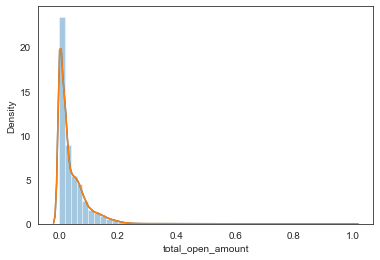

In [43]:
# Distribution plot of total_open_amount
# Right skewed distribution
print(sns.distplot(X_train['total_open_amount']))
sns.set_style('white')
print(sns.kdeplot(X_train['total_open_amount']))

In [44]:
# Standard Deviation Method

# seed the random number generator
seed(1)

# Calculate summary statistics
data_mean, data_std = mean(X_train['total_open_amount']), std(X_train['total_open_amount'])

# Identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off

# Count outliers
outliers = [x for x in X_train['total_open_amount'] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))

# Count non-outliers
outliers_removed = [x for x in X_train['total_open_amount'] if x >= lower and x <= upper]
print('Non-outlier observations: %d' % len(outliers_removed))

# Actually remove the outliers
X_train = X_train[(X_train['total_open_amount'] >= lower) & (X_train['total_open_amount'] <= upper)]

Identified outliers: 453
Non-outlier observations: 26260


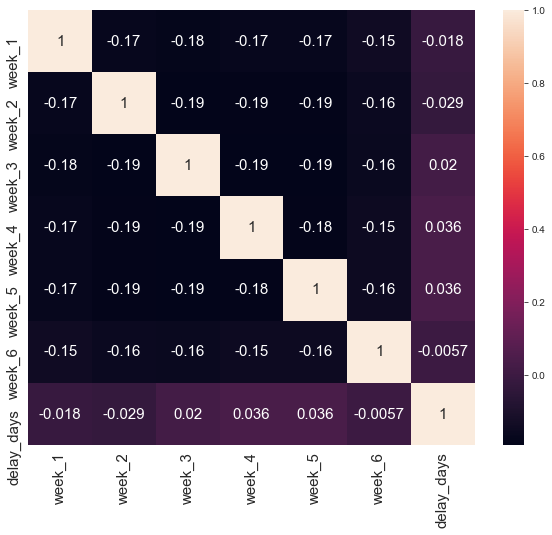

In [45]:
# Lets see if there is any corelation between weekday and delay_days
plt.figure(figsize = (10, 8))
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
columns = ['week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6', 'delay_days']
sns.heatmap(X_train[columns].corr(), annot = True,
            annot_kws = {'size' : 15})
plt.show()

# From the graph we can see that weeks don't have high corelation between themselves, 
# But seems to have small corelations with the target column 

In [46]:
X_train.columns

Index(['total_open_amount', 'delay_days', 'total_duration',
       'business_code_enc', 'cust_number_enc', 'cust_payment_terms_enc',
       'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6'],
      dtype='object')

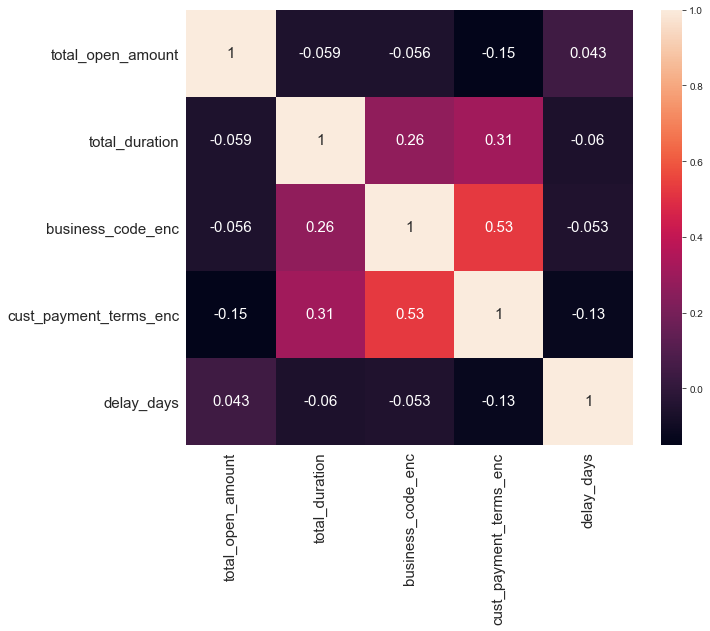

In [47]:
# Let's now check other columns for the corelation
plt.figure(figsize = (10, 8))
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
columns = ['total_open_amount', 'total_duration', 'business_code_enc', 'cust_payment_terms_enc', 'delay_days']
sns.heatmap(X_train[columns].corr(), annot = True,
            annot_kws = {'size' : 15})
plt.show()

In [48]:
print(X_train.columns)
X_train_sel = X_train.drop(['delay_days'], axis = 1, inplace = False)
y_train_sel = X_train['delay_days']

Index(['total_open_amount', 'delay_days', 'total_duration',
       'business_code_enc', 'cust_number_enc', 'cust_payment_terms_enc',
       'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6'],
      dtype='object')


In [49]:
# Sequential Forward Selection(sfs)
sfs = SFS(LinearRegression(), k_features = 6, forward = True, floating = False, scoring = 'r2', cv = 0)
sfs.fit(X_train_sel, y_train_sel)
sfs.k_feature_names_

('total_open_amount',
 'cust_number_enc',
 'cust_payment_terms_enc',
 'week_3',
 'week_4',
 'week_5')

In [50]:
# Dropping columns because of feature selection
X_train.drop(['total_duration', 'business_code_enc', 'week_1', 'week_2', 'week_6'], axis = 1, inplace = True)
y_train = X_train['delay_days']
X_train.drop(['delay_days'], axis = 1, inplace = True)

In [51]:
# Preparing validation data
X_val.head()

,business_code,cust_number,buisness_year,posting_date,document_create_date,due_in_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms,total_duration
35277,CA02,0140104340,2019.0,2019-11-05,2019-11-05,2019-11-17,CAD,58.08,2019-11-07,CA10,12
35278,U001,0200762301,2019.0,2019-09-11,2019-09-10,2019-09-26,USD,59951.35,2019-09-11,NAC6,15
35279,U001,0200726979,2019.0,2019-04-16,2019-04-15,2019-05-01,USD,16319.95,2019-04-16,NAA8,15
35280,U001,0200776463,2019.0,2019-10-26,2019-10-26,2019-11-10,USD,38248.39,2019-10-26,NAA8,15
35282,U001,0200778870,2019.0,2019-03-15,2019-03-15,2019-03-30,USD,27722.36,2019-03-15,NAA8,15


In [52]:
def mapper_for_val_and_test(val):
    
    # Currency convertor
    cur_covt = CurrencyConverter()
    rate = cur_covt.convert(1, 'CAD', 'USD')
    val.loc[df['invoice_currency'] == 'CAD', 'total_open_amount'] = val['total_open_amount'] * rate

    # Delete columns
    val.drop(['buisness_year', 'posting_date', 'document_create_date',
              'baseline_create_date', 'invoice_currency'], axis = 1, inplace = True)
    
    # Label encoding
    # For business_code
    enc = LabelEncoder()
    enc.fit(val['business_code'])
    val['business_code_enc'] = enc.transform(val['business_code'])

    # For cust_number
    enc = LabelEncoder()
    enc.fit(val['cust_number'])
    val['cust_number_enc'] = enc.transform(val['cust_number'])

    # For cust_payment_terms
    enc = LabelEncoder()
    enc.fit(val['cust_payment_terms'])
    val['cust_payment_terms_enc'] = enc.transform(val['cust_payment_terms'])

    # Drop object type columns
    val.drop(['business_code', 'cust_number', 'cust_payment_terms'], axis = 1, inplace = True)
    
    val['total_open_amount'] = (val['total_open_amount'] - val['total_open_amount'].min()) / (val['total_open_amount'].max() - val['total_open_amount'].min())
    val['total_duration'] = (val['total_duration'] - val['total_duration'].min()) / (val['total_duration'].max() - val['total_duration'].min())
    val['business_code_enc'] = (val['business_code_enc'] - val['business_code_enc'].min()) / (val['business_code_enc'].max() - val['business_code_enc'].min())
    val['cust_number_enc'] = (val['cust_number_enc'] - val['cust_number_enc'].min()) / (val['cust_number_enc'].max() - val['cust_number_enc'].min())
    val['cust_payment_terms_enc'] = (val['cust_payment_terms_enc'] - val['cust_payment_terms_enc'].min()) / (val['cust_payment_terms_enc'].max() - val['cust_payment_terms_enc'].min())

    # Get month from due date
    val['week_days'] = val['due_in_date'].dt.weekday
    val = pd.get_dummies(val, columns = ['week_days'], prefix = 'week', drop_first = True)
    val.drop(['due_in_date'], axis = 1, inplace = True)
    
    # Dropping columns because of feature selection
    val.drop(['total_duration', 'business_code_enc', 'week_1', 'week_2', 'week_6'], axis = 1, inplace = True)
    
    return val

X_val = mapper_for_val_and_test(X_val)

In [53]:
# Looking at the validation data it is ready to fit in the model
print(X_val.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11744 entries, 35277 to 49999
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   total_open_amount       11744 non-null  float64
 1   cust_number_enc         11744 non-null  float64
 2   cust_payment_terms_enc  11744 non-null  float64
 3   week_3                  11744 non-null  uint8  
 4   week_4                  11744 non-null  uint8  
 5   week_5                  11744 non-null  uint8  
dtypes: float64(3), uint8(3)
memory usage: 659.4 KB
None


In [54]:
# Shape of data
print("Train      data: ", X_train.shape, y_train.shape)
print("Validation data: ", X_val.shape)

Train      data:  (26260, 6) (26260,)
Validation data:  (11744, 6)


## Modelling

In [55]:
# Defining Lists to Store in the Results and Names of Algorithms
MSE_Score = []
R2_Score = []
Algorithm = []

In [56]:
Algorithm.append('Linear Regression')
clf = LinearRegression()
clf.fit(X_train, y_train)

# Predicting the Test Set Results
predicted = clf.predict(X_val)

In [57]:
# Appending the Scores For Visualisation at a Later Part
MSE_Score.append(mean_squared_error(y_val, predicted))
R2_Score.append(r2_score(y_val, predicted))

In [58]:
# Fitting SVR to the Training Set
Algorithm.append('Support Vector Regression')
clf = SVR()
clf.fit(X_train, y_train)

# Predicting the Test Set Results
predicted = clf.predict(X_val)

In [59]:
# Appending the Scores For Visualisation at a Later Part
MSE_Score.append(mean_squared_error(y_val, predicted))
R2_Score.append(r2_score(y_val, predicted))

In [60]:
# Fitting Random Forest Regressor Tree to the Training Set
Algorithm.append('Random Forest Regressor')
clf = RandomForestRegressor()
clf.fit(X_train, y_train)

# Predicting the Test Set Results
predicted = clf.predict(X_val)

In [61]:
# Appending the Scores For Visualisation at a Later Part
MSE_Score.append(mean_squared_error(y_val, predicted))
R2_Score.append(r2_score(y_val, predicted))

In [62]:
# Fitting XGBoost Regressor to the Training Set
Algorithm.append('XGB Regressor')
clf = xgb.XGBRegressor()
clf.fit(X_train, y_train)

# Predicting the Test Set Results
predicted = clf.predict(X_val)

In [63]:
# Appending the Scores For Visualisation at a Later Part
MSE_Score.append(mean_squared_error(y_val, predicted))
R2_Score.append(r2_score(y_val, predicted))

In [64]:
Comparison = pd.DataFrame(list(zip(Algorithm, MSE_Score, R2_Score)), columns = ['Algorithm', 'MSE_Score', 'R2_Score'])

In [65]:
Comparison

,Algorithm,MSE_Score,R2_Score
0,Linear Regression,114.360178,-0.005686
1,Support Vector Regression,97.381805,0.143623
2,Random Forest Regressor,92.524433,0.186338
3,XGB Regressor,90.777181,0.201704


## Predicting real time test data

In [66]:
# This is the data which was separated at the first place
real_time_test_data.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id
4,U001,0200799367,MCL co,NaN,2020.0,1.930598e+09,2020-03-11,20200304,20200311,20200326.0,USD,RV,1.0,NaN,7617.62,20200311.0,NAA8,1.930598e+09
9,CA02,0140104429,COSTCO corp,NaN,2020.0,2.960625e+09,2020-04-03,20200403,20200403,20200415.0,CAD,RV,1.0,NaN,76352.49,20200405.0,CA10,2.960625e+09
12,U001,0200772670,ASSOCIAT,NaN,2020.0,1.930740e+09,2020-04-03,20200403,20200403,20200418.0,USD,RV,1.0,NaN,53807.73,20200403.0,NAU5,1.930740e+09
22,U001,0200772670,ASSOCIAT systems,NaN,2020.0,1.930744e+09,2020-04-03,20200404,20200403,20200418.0,USD,RV,1.0,NaN,21856.77,20200403.0,NAU5,1.930744e+09
36,U001,0200769623,WAL-MAR systems,NaN,2020.0,1.930774e+09,2020-04-10,20200410,20200410,20200425.0,USD,RV,1.0,NaN,18485.94,20200410.0,NAH4,1.930774e+09


In [67]:
def mapper_for_real_time_test_data(val):

    # Delete columns
    val.drop(['business_code', 'name_customer', 'doc_id', 'invoice_id', 'clear_date', 'buisness_year', 'document_create_date',
              'baseline_create_date', 'document_create_date', 'document_create_date.1', 'document type',
              'posting_id', 'area_business', 'baseline_create_date'], axis = 1, inplace = True)
    
    # Currency convertor
    cur_covt = CurrencyConverter()
    rate = cur_covt.convert(1, 'CAD', 'USD')
    val.loc[df['invoice_currency'] == 'CAD', 'total_open_amount'] = val['total_open_amount'] * rate
    val.drop(['invoice_currency'], axis = 1, inplace = True)
    
    # Label encoding
    # For cust_number
    enc = LabelEncoder()
    enc.fit(val['cust_number'])
    val['cust_number_enc'] = enc.transform(val['cust_number'])

    # For cust_payment_terms
    enc = LabelEncoder()
    enc.fit(val['cust_payment_terms'])
    val['cust_payment_terms_enc'] = enc.transform(val['cust_payment_terms'])

    # Drop object type columns
    val.drop(['cust_number', 'cust_payment_terms'], axis = 1, inplace = True)
    
    # Calculate total duration
    # Function to handle special datetime format with no space, or any special characters
    def handle_no_space_date(raw_date):

        raw_date = str(raw_date)
        y = raw_date[0:4]
        m = raw_date[4:6]
        d = raw_date[6:8]

        return y + '-' + m + '-' + d
    
    val['posting_date'] = pd.to_datetime(val['posting_date'])
    val['due_in_date'] = pd.to_datetime(val['due_in_date'].apply(handle_no_space_date))
#     val['total_duration'] = (val['due_in_date'] - val['posting_date']).dt.days
    
    # Normalising all values between 0 and 1
    val['total_open_amount'] = (val['total_open_amount'] - val['total_open_amount'].min()) / (val['total_open_amount'].max() - val['total_open_amount'].min())
#    val['total_duration'] = (val['total_duration'] - val['total_duration'].min()) / (val['total_duration'].max() - val['total_duration'].min())
    val['cust_number_enc'] = (val['cust_number_enc'] - val['cust_number_enc'].min()) / (val['cust_number_enc'].max() - val['cust_number_enc'].min())
    val['cust_payment_terms_enc'] = (val['cust_payment_terms_enc'] - val['cust_payment_terms_enc'].min()) / (val['cust_payment_terms_enc'].max() - val['cust_payment_terms_enc'].min())

    # Get month from due date
    val['week_days'] = val['due_in_date'].dt.weekday
    val = pd.get_dummies(val, columns = ['week_days'], prefix = 'week', drop_first = True)
    val.drop(['due_in_date', 'posting_date', 'week_1', 'week_2', 'week_6'], axis = 1, inplace = True)
    
    return val

In [68]:
real_time_test_data = mapper_for_real_time_test_data(real_time_test_data)

In [69]:
# Fitting Random Forest Regressor Tree to the real time test set
# As the data is non-linear and doesn't provide much efficiency on Linear regression.
# As there are not many features, Bagging can be used as,
#  It helps making more features by generating more trees.
#  It also helps with the issue of over-fitting.
Algorithm.append('Random Forest Regressor')
clf = RandomForestRegressor()
clf.fit(X_train, y_train)

# Predicting the Test Set Results
predicted = clf.predict(real_time_test_data)

In [70]:
# Append predictions to the final dataset
pred_delay_days = pd.Series(predicted.astype(int), name = 'predicted_delay_days')
final_data = final_data.merge(pred_delay_days, on = final_data.index)

In [71]:
# Function to handle special datetime format with no space, or any special characters
def handle_no_space_date(raw_date):
    
    raw_date = str(raw_date)
    y = raw_date[0:4]
    m = raw_date[4:6]
    d = raw_date[6:8]
    
    return y + '-' + m + '-' + d

final_data['due_in_date'] = pd.to_datetime(final_data['due_in_date'].apply(handle_no_space_date))

# Drop null clear_date column
final_data.drop(['clear_date'], axis = 1, inplace = True)

# Calculating to predicted_clear_date -> (due_date + delay_days) and append to final dataset
final_data['predicted_clear_date'] = final_data['due_in_date'] + pd.to_timedelta(pd.np.ceil(final_data['predicted_delay_days']), unit = 'D')

In [72]:
final_data.head()

,key_0,business_code,cust_number,name_customer,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,...,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,predicted_delay_days,predicted_clear_date
0,4,U001,0200799367,MCL co,2020.0,1.930598e+09,2020-03-11,20200304,20200311,2020-03-26,...,RV,1.0,NaN,7617.62,20200311.0,NAA8,1.930598e+09,1,-16,2020-03-10
1,9,CA02,0140104429,COSTCO corp,2020.0,2.960625e+09,2020-04-03,20200403,20200403,2020-04-15,...,RV,1.0,NaN,76352.49,20200405.0,CA10,2.960625e+09,1,4,2020-04-19
2,12,U001,0200772670,ASSOCIAT,2020.0,1.930740e+09,2020-04-03,20200403,20200403,2020-04-18,...,RV,1.0,NaN,53807.73,20200403.0,NAU5,1.930740e+09,1,2,2020-04-20
3,22,U001,0200772670,ASSOCIAT systems,2020.0,1.930744e+09,2020-04-03,20200404,20200403,2020-04-18,...,RV,1.0,NaN,21856.77,20200403.0,NAU5,1.930744e+09,1,1,2020-04-19
4,36,U001,0200769623,WAL-MAR systems,2020.0,1.930774e+09,2020-04-10,20200410,20200410,2020-04-25,...,RV,1.0,NaN,18485.94,20200410.0,NAH4,1.930774e+09,1,2,2020-04-27


## Bucketing

In [73]:
# Delay bucket map
def bucket_mapper(val):
    
    if val < 0:
        return 'In-advance'
    
    if val <= 15:
        return '0-15 days'
    elif val <= 30:
        return '16-30 days'
    elif val <= 45:
        return '31-45 days'
    elif val <= 60:
        return '46-60 days'
    else:
        return 'More than 50 days'

In [74]:
# Adding delay_bucket column
final_data['delay_bucket'] = final_data['predicted_delay_days'].apply(bucket_mapper)

In [75]:
# Required final data (Added predicted delay_days, clear_date and delay bucket)
final_data.head()

,key_0,business_code,cust_number,name_customer,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,...,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,predicted_delay_days,predicted_clear_date,delay_bucket
0,4,U001,0200799367,MCL co,2020.0,1.930598e+09,2020-03-11,20200304,20200311,2020-03-26,...,1.0,NaN,7617.62,20200311.0,NAA8,1.930598e+09,1,-16,2020-03-10,In-advance
1,9,CA02,0140104429,COSTCO corp,2020.0,2.960625e+09,2020-04-03,20200403,20200403,2020-04-15,...,1.0,NaN,76352.49,20200405.0,CA10,2.960625e+09,1,4,2020-04-19,0-15 days
2,12,U001,0200772670,ASSOCIAT,2020.0,1.930740e+09,2020-04-03,20200403,20200403,2020-04-18,...,1.0,NaN,53807.73,20200403.0,NAU5,1.930740e+09,1,2,2020-04-20,0-15 days
3,22,U001,0200772670,ASSOCIAT systems,2020.0,1.930744e+09,2020-04-03,20200404,20200403,2020-04-18,...,1.0,NaN,21856.77,20200403.0,NAU5,1.930744e+09,1,1,2020-04-19,0-15 days
4,36,U001,0200769623,WAL-MAR systems,2020.0,1.930774e+09,2020-04-10,20200410,20200410,2020-04-25,...,1.0,NaN,18485.94,20200410.0,NAH4,1.930774e+09,1,2,2020-04-27,0-15 days


### Thank You <br>
#### Subham Sagar Paira - H2HBABBA1602